In [2]:
from tqdm import tqdm  # For progress bars
import torch.backends.cudnn as cudnn
import os
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score
import timm
from mydatasets import LeafDiseaseDataset
torch.backends.cudnn.benchmark = True
torch.set_default_dtype(torch.float32)
if torch.backends.mps.is_available():
    device = torch.device("mps")       # Since My system is Macbook(does not support CUDA) , so I am using MPS
else:
    device = torch.device("cpu")
# Adding multiprocessing initialization to prevent crashes or unexpected behaviour during training 
if __name__ == '__main__':
    # For macOS,we need to use 'spawn' instead of 'fork'
    import multiprocessing as mp
    mp.set_start_method('spawn', force=True)

In [3]:
# Data Pre Processing Stage
from PIL import Image
# Defining transforms for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # Using Data Augumentation which helps in mitigating overfitting issues and often lead to more robust and reliable result
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # Converts the image from a PIL Image or NumPy array into a PyTorch tensor(shape = [2, 224, 224])
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Using ImageNet normalization
        std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def combine_datasets(csv_files, root_dirs, transform):
    datasets = []
    for csv_file, root_dir in zip(csv_files, root_dirs):
        dataset = LeafDiseaseDataset(csv_file, root_dir, transform=transform)
        datasets.append(dataset)
    # Concatenate datasets (this uses the torch.utils.data.ConcatDataset)
    from torch.utils.data import ConcatDataset
    combined_dataset = ConcatDataset(datasets)
    return combined_dataset

# I have used relative paths for csv files and you replace it (if required)
csv_files = [
    "paddy_disease_train.csv",
    "rice_leaf_disease_images.csv"
]
# List of corresponding image directories. I have used relative paths for dataset directories and you replace it (if required)
root_dirs = [
    "paddy_train_images",
    "Rice Leaf Disease Images"
]
# Create the combined dataset using the training transforms
combined_train_dataset = combine_datasets(csv_files, root_dirs, transform=train_transforms)
train_size = int(0.8 * len(combined_train_dataset))
val_size = len(combined_train_dataset) - train_size
train_dataset, val_dataset = random_split(combined_train_dataset, [train_size, val_size])
batch_size = 64  # Increased for faster training
num_workers = 0  # Enable parallel data loading
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True
)

In [5]:
def get_cnn_model(num_classes, feature_extract=True):
    # Use EfficientNet-B7 (tf_efficientnet_b7_ns) as the state-of-the-art CNN model
    model = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
    if feature_extract:
        # Freeze all parameters first
        for param in model.parameters():
            param.requires_grad = False
        # Replace the classifier head with a new layer for our 10 classes
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        # Unfreeze only the classifier head parameters(i.e Final/Output Layer(s)) for training
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

def get_transformer_model(num_classes, feature_extract=True):
    # Use a larger Vision Transformer model (ViT Base) for higher accuracy
    model = timm.create_model("vit_base_patch16_224", pretrained=True)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    # Adjust the classifier head to output num_classes logits
    if hasattr(model, "head"):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
    else:
        in_features = model.get_classifier().in_features
        model.reset_classifier(num_classes)
    return model.to(device)
    
num_classes = len(combined_train_dataset.datasets[0].class_to_idx)
print(f"Number of classes: {num_classes}")


Number of classes: 10


In [6]:
""" Args:
        model: The PyTorch model.
        dataloaders: A dict containing 'train' and 'val' DataLoaders.
        criterion: Loss function.
        optimizer: Optimizer.
        scheduler: Learning rate scheduler.
        num_epochs: Number of training epochs.
        patience: The number of epochs to wait for an improvement in validation loss before early stopping is triggered."""
class Trainer:
    def __init__(self, model, dataloaders, criterion, optimizer, scheduler, num_epochs=25,patience=5):
        self.model = model
        self.dataloaders = dataloaders
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epochs = num_epochs
        self.best_model_wts = copy.deepcopy(model.state_dict())
        self.best_acc = 0.0
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def train_model(self):
        since = time.time()
        torch.cuda.empty_cache()  # Clear cache before training
        
        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch+1}/{self.num_epochs}")
            print("-" * 10)
            #In each epoch it undergoes training phase and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()  # We set our model to training mode
                else:
                    self.model.eval()
                    
                running_loss = 0.0
                running_corrects = 0
                
                # Use tqdm for progress bar
                for inputs, labels in tqdm(self.dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    self.optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)  #Forward Pass
                        _, preds = torch.max(outputs, 1)  
                        loss = self.criterion(outputs, labels)  
                        
                        if phase == 'train':
                            loss.backward() # Back propogation
                            self.optimizer.step()  #Updating model weights using optimizer
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / len(self.dataloaders[phase].dataset)
                epoch_acc = running_corrects.float() / len(self.dataloaders[phase].dataset)
                
                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                
                if phase == 'train':
                    self.train_loss_history.append(epoch_loss)
                    self.train_acc_history.append(epoch_acc.item())
                    self.scheduler.step()
                else:
                    self.val_loss_history.append(epoch_loss)
                    self.val_acc_history.append(epoch_acc.item())
                    if epoch_acc > self.best_acc:
                        self.best_acc = epoch_acc
                        self.best_model_wts = copy.deepcopy(self.model.state_dict())
            
            print()
        
        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best val Acc: {self.best_acc:.4f}")
        
        self.model.load_state_dict(self.best_model_wts)
        return self.model
    def evaluate(self, dataloader):
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        return acc, precision, recall

In [8]:

def run_experiment(model_type='cnn', num_epochs=10, learning_rate=2e-3):
    if model_type == 'cnn':
        model = get_cnn_model(num_classes=num_classes, feature_extract=True)
        print("Training SOTA CNN model...")
    elif model_type == 'transformer':
        model = get_transformer_model(num_classes=num_classes, feature_extract=True)
        print("Training SOTA Transformer model...")
    else:
        raise ValueError("Unsupported model type. Choose 'cnn' or 'transformer'.")
    
    criterion = nn.CrossEntropyLoss()   # Loss Function is Cross Entropy
    # Here I am using ADAMW which has decoupled weight decay term in updating equation which is for faster convergence and More Generalization
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=learning_rate, 
                           weight_decay=0.01)  
    
    # Using OneCycleLR for better convergence
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )
    
    dataloaders = {'train': train_loader, 'val': val_loader}
    trainer = Trainer(model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs)
    best_model = trainer.train_model()
    
    # Evaluate and plot results
    acc, precision, recall = trainer.evaluate(val_loader)
    print(f"Validation Metrics for {model_type.upper()}:")
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    # Plot training history
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, trainer.train_loss_history, label='Train Loss')
    plt.plot(epochs, trainer.val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type.upper()} Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, trainer.train_acc_history, label='Train Acc')
    plt.plot(epochs, trainer.val_acc_history, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_type.upper()} Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return best_model, trainer

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b7_ns to current tf_efficientnet_b7.ns_jft_in1k.
  model = create_fn(


Training SOTA CNN model...
Epoch 1/15
----------


100%|██████████| 205/205 [08:56<00:00,  2.62s/it]


train Loss: 2.1002 Acc: 0.3006


100%|██████████| 52/52 [01:56<00:00,  2.25s/it]


val Loss: 1.9723 Acc: 0.3892

Epoch 2/15
----------


100%|██████████| 205/205 [09:00<00:00,  2.64s/it]


train Loss: 1.8704 Acc: 0.4377


100%|██████████| 52/52 [01:56<00:00,  2.25s/it]


val Loss: 1.8282 Acc: 0.4529

Epoch 3/15
----------


100%|██████████| 205/205 [09:06<00:00,  2.67s/it]


train Loss: 1.7245 Acc: 0.4863


100%|██████████| 52/52 [01:59<00:00,  2.30s/it]


val Loss: 1.7141 Acc: 0.4884

Epoch 4/15
----------


100%|██████████| 205/205 [09:11<00:00,  2.69s/it]


train Loss: 1.6298 Acc: 0.5175


100%|██████████| 52/52 [01:58<00:00,  2.28s/it]


val Loss: 1.6454 Acc: 0.4878

Epoch 5/15
----------


100%|██████████| 205/205 [09:18<00:00,  2.72s/it]


train Loss: 1.5597 Acc: 0.5288


100%|██████████| 52/52 [02:02<00:00,  2.36s/it]


val Loss: 1.5851 Acc: 0.5229

Epoch 6/15
----------


100%|██████████| 205/205 [09:20<00:00,  2.73s/it]


train Loss: 1.5024 Acc: 0.5442


100%|██████████| 52/52 [02:00<00:00,  2.32s/it]


val Loss: 1.5417 Acc: 0.5355

Epoch 7/15
----------


100%|██████████| 205/205 [10:01<00:00,  2.93s/it]


train Loss: 1.4542 Acc: 0.5550


100%|██████████| 52/52 [02:03<00:00,  2.38s/it]


val Loss: 1.4997 Acc: 0.5352

Epoch 8/15
----------


100%|██████████| 205/205 [09:41<00:00,  2.84s/it]


train Loss: 1.4231 Acc: 0.5562


100%|██████████| 52/52 [02:08<00:00,  2.47s/it]


val Loss: 1.4706 Acc: 0.5401

Epoch 9/15
----------


100%|██████████| 205/205 [09:34<00:00,  2.80s/it]


train Loss: 1.3900 Acc: 0.5675


100%|██████████| 52/52 [02:01<00:00,  2.33s/it]


val Loss: 1.4300 Acc: 0.5496

Epoch 10/15
----------


100%|██████████| 205/205 [09:39<00:00,  2.83s/it]


train Loss: 1.3642 Acc: 0.5765


100%|██████████| 52/52 [02:00<00:00,  2.32s/it]


val Loss: 1.4183 Acc: 0.5575

Epoch 11/15
----------


100%|██████████| 205/205 [09:41<00:00,  2.83s/it]


train Loss: 1.3402 Acc: 0.5817


100%|██████████| 52/52 [02:01<00:00,  2.33s/it]


val Loss: 1.3782 Acc: 0.5731

Epoch 12/15
----------


100%|██████████| 205/205 [09:29<00:00,  2.78s/it]


train Loss: 1.3236 Acc: 0.5843


100%|██████████| 52/52 [02:01<00:00,  2.34s/it]


val Loss: 1.3657 Acc: 0.5734

Epoch 13/15
----------


100%|██████████| 205/205 [09:23<00:00,  2.75s/it]


train Loss: 1.2978 Acc: 0.5921


100%|██████████| 52/52 [02:07<00:00,  2.45s/it]


val Loss: 1.3523 Acc: 0.5643

Epoch 14/15
----------


100%|██████████| 205/205 [09:36<00:00,  2.81s/it]


train Loss: 1.2782 Acc: 0.5963


100%|██████████| 52/52 [02:01<00:00,  2.33s/it]


val Loss: 1.3408 Acc: 0.5802

Epoch 15/15
----------


100%|██████████| 205/205 [09:26<00:00,  2.77s/it]


train Loss: 1.2663 Acc: 0.5995


100%|██████████| 52/52 [01:56<00:00,  2.25s/it]


val Loss: 1.3058 Acc: 0.5958

Training complete in 171m 47s
Best val Acc: 0.5958
Validation Metrics for CNN:
Accuracy: 0.5808, Precision: 0.5815, Recall: 0.5808


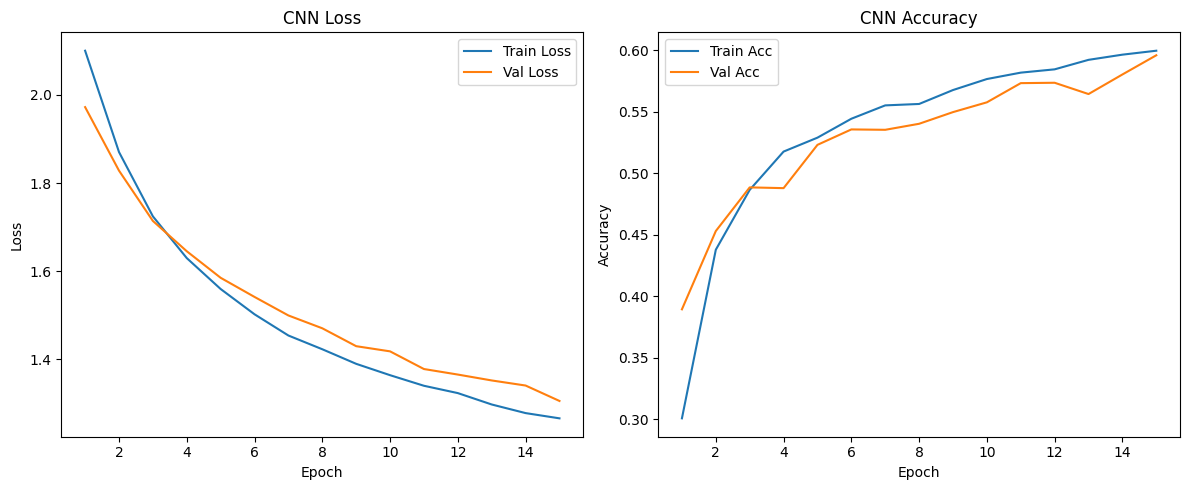

In [7]:
if __name__ == "__main__":
    # Try with fewer epochs but higher learning rate
    cnn_model, cnn_trainer = run_experiment(
        model_type='cnn', 
        num_epochs=15, 
        learning_rate=2e-3
    )

Training SOTA Transformer model...
Epoch 1/15
----------


100%|██████████| 205/205 [08:33<00:00,  2.50s/it]


train Loss: 1.7575 Acc: 0.4073


100%|██████████| 52/52 [02:18<00:00,  2.66s/it]


val Loss: 1.3378 Acc: 0.5734

Epoch 2/15
----------


100%|██████████| 205/205 [08:48<00:00,  2.58s/it]


train Loss: 1.2215 Acc: 0.6081


100%|██████████| 52/52 [02:13<00:00,  2.56s/it]


val Loss: 1.1217 Acc: 0.6463

Epoch 3/15
----------


100%|██████████| 205/205 [09:08<00:00,  2.68s/it]


train Loss: 1.0590 Acc: 0.6647


100%|██████████| 52/52 [02:24<00:00,  2.78s/it]


val Loss: 1.0101 Acc: 0.6717

Epoch 4/15
----------


100%|██████████| 205/205 [09:27<00:00,  2.77s/it]


train Loss: 0.9606 Acc: 0.6947


100%|██████████| 52/52 [02:20<00:00,  2.71s/it]


val Loss: 0.9275 Acc: 0.6940

Epoch 5/15
----------


100%|██████████| 205/205 [09:32<00:00,  2.79s/it]


train Loss: 0.8969 Acc: 0.7170


100%|██████████| 52/52 [02:23<00:00,  2.76s/it]


val Loss: 0.8718 Acc: 0.7209

Epoch 6/15
----------


100%|██████████| 205/205 [09:42<00:00,  2.84s/it]


train Loss: 0.8403 Acc: 0.7367


100%|██████████| 52/52 [02:29<00:00,  2.87s/it]


val Loss: 0.8268 Acc: 0.7295

Epoch 7/15
----------


100%|██████████| 205/205 [09:59<00:00,  2.92s/it]


train Loss: 0.7964 Acc: 0.7483


100%|██████████| 52/52 [02:30<00:00,  2.89s/it]


val Loss: 0.7982 Acc: 0.7417

Epoch 8/15
----------


100%|██████████| 205/205 [09:55<00:00,  2.91s/it]


train Loss: 0.7658 Acc: 0.7598


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


val Loss: 0.7596 Acc: 0.7515

Epoch 9/15
----------


100%|██████████| 205/205 [09:45<00:00,  2.86s/it]


train Loss: 0.7343 Acc: 0.7706


100%|██████████| 52/52 [02:26<00:00,  2.82s/it]


val Loss: 0.7301 Acc: 0.7674

Epoch 10/15
----------


100%|██████████| 205/205 [09:59<00:00,  2.93s/it]


train Loss: 0.7100 Acc: 0.7792


100%|██████████| 52/52 [02:40<00:00,  3.08s/it]


val Loss: 0.7147 Acc: 0.7739

Epoch 11/15
----------


100%|██████████| 205/205 [10:17<00:00,  3.01s/it]


train Loss: 0.6803 Acc: 0.7901


100%|██████████| 52/52 [02:10<00:00,  2.52s/it]


val Loss: 0.6881 Acc: 0.7803

Epoch 12/15
----------


100%|██████████| 205/205 [09:08<00:00,  2.67s/it]


train Loss: 0.6666 Acc: 0.7930


100%|██████████| 52/52 [02:15<00:00,  2.60s/it]


val Loss: 0.6769 Acc: 0.7849

Epoch 13/15
----------


100%|██████████| 205/205 [09:07<00:00,  2.67s/it]


train Loss: 0.6502 Acc: 0.7989


100%|██████████| 52/52 [02:15<00:00,  2.61s/it]


val Loss: 0.6498 Acc: 0.7913

Epoch 14/15
----------


100%|██████████| 205/205 [09:38<00:00,  2.82s/it]


train Loss: 0.6323 Acc: 0.8061


100%|██████████| 52/52 [02:20<00:00,  2.71s/it]


val Loss: 0.6496 Acc: 0.7904

Epoch 15/15
----------


100%|██████████| 205/205 [09:21<00:00,  2.74s/it]


train Loss: 0.6202 Acc: 0.8097


100%|██████████| 52/52 [02:19<00:00,  2.68s/it]


val Loss: 0.6278 Acc: 0.8045

Training complete in 178m 3s
Best val Acc: 0.8045
Validation Metrics for TRANSFORMER:
Accuracy: 0.8005, Precision: 0.8030, Recall: 0.8005


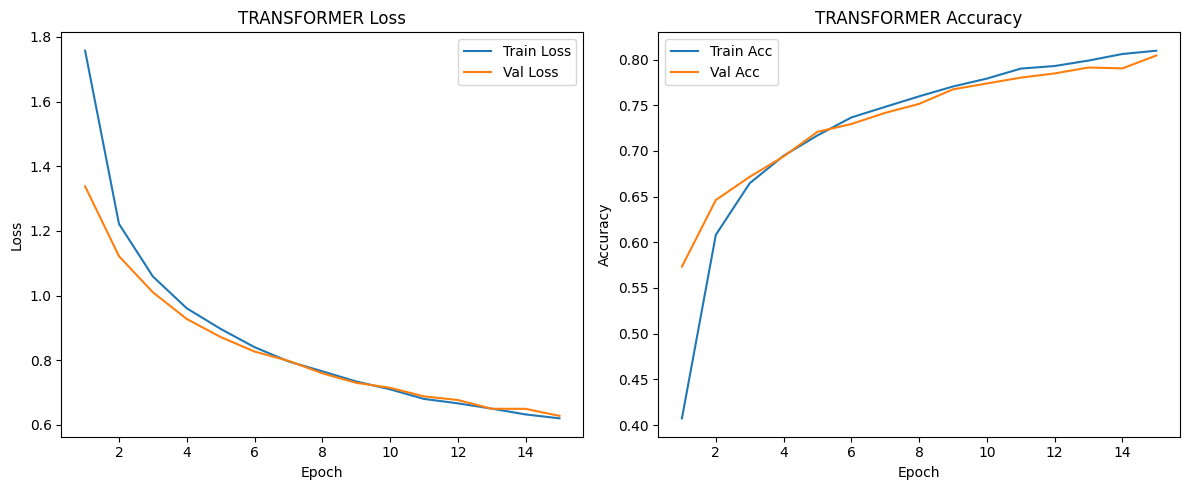

In [12]:
transformer_model, transformer_trainer = run_experiment(
        model_type='transformer', 
        num_epochs=15, 
        learning_rate=2e-3
)
# Saving the transformer model
torch.save(transformer_model.state_dict(), "transformer_model.pth")


In [15]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # List only .jpg files (adjust if your images have a different extension)
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create the test dataset and DataLoader (using the same val_transforms as before)
test_dataset = TestDataset("test_images", transform=val_transforms)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True
)

def generate_predictions(model, dataloader):
    model.eval()
    image_ids = []
    predictions = []
    
    with torch.no_grad():
        for inputs, img_names in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            image_ids.extend(img_names)
            predictions.extend(preds)
    
    # Map predicted indices to class labels using the training dataset's mapping
    idx_to_class = {v: k for k, v in combined_train_dataset.datasets[0].class_to_idx.items()}
    pred_labels = [idx_to_class[p] for p in predictions]
    
    # Create a DataFrame and save the results as CSV
    df = pd.DataFrame({"image_id": image_ids, "predicted_label": pred_labels})
    return df

# Recreate the model architecture
transformer_model = get_transformer_model(num_classes=num_classes, feature_extract=True)
# Load the saved weights (adjust map_location if needed)
transformer_model.load_state_dict(torch.load("transformer_model.pth", map_location=device))
transformer_model.to(device)


# predictions for both the CNN and Transformer models
df1 = generate_predictions(transformer_model, test_loader)

print("The predictions using Tranformer (vit_base_patch16_224) model\n")
df1.to_csv("Test_Labels-2.csv")
df1



100%|██████████| 55/55 [02:18<00:00,  2.52s/it]

The predictions using Tranformer (vit_base_patch16_224) model



,image_id,predicted_label
0,202919.jpg,hispa
1,200868.jpg,normal
2,200698.jpg,tungro
3,200840.jpg,normal
4,201586.jpg,brown_spot
...,...,...
3464,200681.jpg,blast
3465,200871.jpg,tungro
3466,202900.jpg,bacterial_panicle_blight
3467,202914.jpg,blast
